# 基于机器学习的pyborker量化交易策略

In [1]:
import pybroker
from pybroker.ext.data import AKShare
from pybroker import ExecContext, StrategyConfig, Strategy
from pybroker.data import DataSource
import matplotlib.pyplot as plt
from datetime import datetime
import riskfolio as rp
import akshare as ak
import pandas as pd
import numpy as np
import sqlite3
import datetime
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import talib
from pybroker.vect import cross

#正常显示画图时出现的中文和负号
from pylab import mpl

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

akshare = AKShare()

pybroker.enable_data_source_cache('akshare')

## 基于机器学习算法在策略中的应用

In [2]:
conn=sqlite3.connect(r'I:\量化金融\stock_2018.db')
stock_daily1=pd.read_sql("select * from stock_daily where 股票代码<'003000.SZ'",con=conn)
stock_daily1["交易日期"]=pd.to_datetime(stock_daily1["交易日期"].astype(str))

In [5]:
stock_daily1.columns

Index(['index', '交易日期', '股票代码', '股票简称', '开盘价', '最高价', '最低价', '收盘价', '成交量(手)',
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)'],
      dtype='object')

In [3]:
stock_daily1.columns=['index', "date","symbol", '股票简称', "open","high","low","close","volume",
       '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率',
       '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)',
       '总市值(万元)', '流通市值(万元)']

In [4]:
def func0(x):
    return x.pct_change().shift(-1)

In [5]:
stock_daily1["return_s1"]=stock_daily1.groupby("symbol", group_keys=False).close.apply(func0)

In [6]:
def train_slr0(symbol, train_data, test_data):
    x1=train_data[['close','high','low','volume']]
    y1=train_data['return_s1']
    #model = DecisionTreeRegressor()
    model = GradientBoostingRegressor()
    #model = LinearRegression()
    model.fit(x1, y1)

    x2=test_data[['close','high','low','volume']]
    y2=test_data['return_s1']
    y_pred = model.predict(x2)
    r2 = r2_score(y2, y_pred)
    print(symbol, f'R^2={r2}')

    return model,["close","high","low","volume"]

def hold_long(ctx):
    if not ctx.long_pos():
        # Buy if the next bar is predicted to have a positive return:
        if ctx.preds('slr')[-1] > 0.:
            ctx.buy_shares = ctx.calc_target_shares(0.5)
    else:
        # Sell if the next bar is predicted to have a negative return:
        if ctx.preds('slr')[-1] < 0.:
            ctx.sell_shares = ctx.calc_target_shares(0.5)

In [7]:
pyb_data_pe=stock_daily1[["date","symbol","open","high","low","close","volume","return_s1"]].dropna()

In [8]:
model_slr = pybroker.model('slr', train_slr0)
pybroker.register_columns('return_s1')
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=20,
    windows=3,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-21 00:00:00 to 2019-03-12 00:00:00
000001.SZ R^2=-0.1531093981262832
002594.SZ R^2=-0.242497593008264
Finished training models: 0:00:00 

Test split: 2019-03-13 00:00:00 to 2020-03-03 00:00:00


  0% (0 of 237) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 29% (71 of 237) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 63% (151 of 237) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 97% (231 of 237) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (237 of 237) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-03-13 00:00:00 to 2020-03-03 00:00:00
000001.SZ R^2=-0.34570709077249995
002594.SZ R^2=-0.4779307702234785
Finished training models: 0:00:00 

Test split: 2020-03-04 00:00:00 to 2021-02-23 00:00:00


  0% (0 of 237) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 21% (51 of 237) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 51% (121 of 237) |###########           | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (191 of 237) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (237 of 237) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2020-03-04 00:00:00 to 2021-02-23 00:00:00
000001.SZ R^2=-0.4298399921222975
002594.SZ R^2=-0.4268690708107139
Finished training models: 0:00:00 

Test split: 2021-02-24 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 237) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 29% (71 of 237) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 67% (161 of 237) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (237 of 237) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:06 

Finished backtest: 0:00:12


In [12]:
#result.orders

In [10]:
result.metrics_df.head()

,name,value
0,trade_count,425.00
1,initial_market_value,100000.00
2,end_market_value,110039.32
3,total_pnl,13141.45
4,unrealized_pnl,-3102.13


## 加入所有其他因子

In [13]:
stock_daily1.columns

Index(['index', 'date', 'symbol', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'return_s1'],
      dtype='object')

In [18]:
factor=stock_daily1.columns[4:].tolist()
factor.remove('return_s1')
factor

['open',
 'high',
 'low',
 'close',
 'volume',
 '成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)']

In [26]:
def train_slr1(symbol, train_data, test_data):
    x1=train_data[factor]
    y1=train_data['return_s1']
    #model = DecisionTreeRegressor()
    model = GradientBoostingRegressor()
    #model = LinearRegression()
    model.fit(x1, y1)

    x2=test_data[factor]
    y2=test_data['return_s1']
    y_pred = model.predict(x2)
    r2 = r2_score(y2, y_pred)
    print(symbol, f'R^2={r2}')

    return model,factor

In [29]:
#去掉stock_daily1中'股票简称'列
pyb_data_pe=stock_daily1.drop(columns=['股票简称']).dropna()

In [25]:
factor[5:]+['return_s1']

['成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)',
 'return_s1']

In [30]:
model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor[5:]+['return_s1'])
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=20,
    windows=3,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-23 00:00:00 to 2019-03-07 00:00:00
000001.SZ R^2=-1.3687680810591587
002594.SZ R^2=-0.6578603098779185
Finished training models: 0:00:00 

Test split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 17% (41 of 232) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 47% (111 of 232) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (181 of 232) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00
000001.SZ R^2=-0.24242033544728003
002594.SZ R^2=-0.8807874670302995
Finished training models: 0:00:00 

Test split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 13% (31 of 232) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 47% (111 of 232) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 95% (221 of 232) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00
000001.SZ R^2=-1.4877439327269264
002594.SZ R^2=-0.5236108015544574
Finished training models: 0:00:00 

Test split: 2021-03-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 39% (91 of 232) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (151 of 232) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 86% (201 of 232) |###################   | Elapsed Time: 0:00:00 ETA:   0:00:00
 95% (221 of 232) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:02


In [31]:
result.metrics_df.head()

,name,value
0,trade_count,168.00
1,initial_market_value,100000.00
2,end_market_value,37789.54
3,total_pnl,-60609.23
4,unrealized_pnl,-1601.23


In [21]:
stock_daily1.columns

Index(['index', 'date', 'symbol', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'return_s1'],
      dtype='object')

In [22]:
base_name=["date","symbol","open","high","low","close","volume"]

In [24]:
factor_name=stock_daily1.columns[9:].tolist()
print(factor_name)

['成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'return_s1']


In [30]:
factor_name[:-1]

['成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)']

In [31]:
factor_base=base_name[2:]+factor_name[:-1]
#factor_base

In [55]:
def train_slr1(symbol, train_data, test_data):
    x1=train_data[factor_base]
    y1=train_data['return_s1']
    #model = DecisionTreeRegressor()
    model = GradientBoostingRegressor()
    #model = LinearRegression()
    model.fit(x1, y1)

    x2=test_data[factor_base]
    y2=test_data['return_s1']
    y_pred = model.predict(x2)
    r2 = r2_score(y2, y_pred)
    print(symbol, f'R^2={r2}')

    return model,factor_base

In [32]:
pyb_data_pe=stock_daily1[base_name+factor_name].dropna()

In [34]:
model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor_name)
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=20,
    windows=2,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-21 00:00:00 to 2019-07-01 00:00:00
000001.SZ R^2=-0.722963022603436
002594.SZ R^2=-0.5779074408662241
Finished training models: 0:00:00 

Test split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 19% (61 of 310) |####                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 48% (151 of 310) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (251 of 310) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00
000001.SZ R^2=-0.18297785024491597
002594.SZ R^2=-0.4997214140101587
Finished training models: 0:00:00 

Test split: 2020-11-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 13% (41 of 310) |###                    | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (141 of 310) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 77% (241 of 310) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:02


In [36]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,000001.SZ,2019-07-31,2019-08-01,1550.20,1535.46,31,-456.94,-0.95,-456.94,1,-456.94,None,-14.74,13.10
2,short,000001.SZ,2019-08-01,2019-08-02,1535.46,1503.26,1,32.20,2.14,-424.74,1,32.20,None,-13.65,32.20
3,long,000001.SZ,2019-08-02,2019-08-05,1503.26,1468.87,31,-1066.09,-2.29,-1490.83,1,-1066.09,None,-34.39,12.01
4,short,000001.SZ,2019-08-05,2019-08-06,1468.87,1445.94,2,45.86,1.59,-1444.97,1,45.86,None,-20.20,22.93
5,long,000001.SZ,2019-08-06,2019-08-08,1445.94,1547.47,31,3147.43,7.02,1702.46,2,1573.72,None,-23.47,101.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,short,000001.SZ,2021-12-22,2021-12-27,1955.28,1931.21,1,24.07,1.25,-56001.16,3,8.02,None,-19.02,29.10
163,long,000001.SZ,2021-12-27,2022-01-12,1931.21,1922.26,9,-80.55,-0.46,-56081.71,11,-7.32,None,-120.31,31.90
164,short,000001.SZ,2022-01-12,2022-01-13,1922.26,1906.03,1,16.23,0.85,-56065.48,1,16.23,None,-30.78,30.78


## 自定义因子-20日均值

In [32]:
# 基于talib库的20日平均
def func0(x):
    return talib.SMA(x, timeperiod=20)

stock_daily1["SMA20_close"]=stock_daily1.groupby("symbol", group_keys=False).close.apply(func0)

In [37]:
factor=stock_daily1.columns[4:].tolist()
factor.remove('return_s1')
factor

['open',
 'high',
 'low',
 'close',
 'volume',
 '成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)',
 'SMA20_close']

In [38]:
pyb_data_pe=stock_daily1.drop(columns=['股票简称']).dropna()

In [39]:
model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor[5:]+['return_s1'])
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=20,
    windows=3,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-23 00:00:00 to 2019-03-07 00:00:00
000001.SZ R^2=-1.0609735892383951
002594.SZ R^2=-0.749404328309192
Finished training models: 0:00:00 

Test split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 30% (71 of 232) |#######                | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (151 of 232) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 82% (191 of 232) |##################    | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00
000001.SZ R^2=-0.8046091816253069
002594.SZ R^2=-0.9483795987633561
Finished training models: 0:00:00 

Test split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 39% (91 of 232) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (181 of 232) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00
000001.SZ R^2=-2.0076339697518653
002594.SZ R^2=-0.9644746385509555
Finished training models: 0:00:01 

Test split: 2021-03-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 34% (81 of 232) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 69% (161 of 232) |###############       | Elapsed Time: 0:00:00 ETA:   0:00:00
 99% (231 of 232) |##################### | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:03


In [35]:
factor

['open',
 'high',
 'low',
 'close',
 'volume',
 '成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)']

In [34]:
#stock_daily1

In [38]:
stock_daily1.columns

Index(['index', 'date', 'symbol', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'return_s1', 'SMA20_close'],
      dtype='object')

In [41]:
base_name

['date', 'symbol', 'open', 'high', 'low', 'close', 'volume']

In [45]:
factor_name=stock_daily1.columns[9:].tolist()
factor_name.remove('return_s1')
factor_name

['成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)',
 'SMA20_close']

In [46]:
factor_base=base_name[2:]+factor_name

In [50]:
#factor_base

In [47]:
pyb_data_pe=stock_daily1[base_name+factor_name+["return_s1"]].dropna()

In [48]:
pyb_data_pe.columns

Index(['date', 'symbol', 'open', 'high', 'low', 'close', 'volume', '成交额(千元)',
       '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率',
       '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)',
       '流通市值(万元)', 'SMA20_close', 'return_s1'],
      dtype='object')

In [63]:
model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor_name+["return_s1"])
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=30,
    windows=2,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)


Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-21 00:00:00 to 2019-07-01 00:00:00
000001.SZ R^2=-6.012485786665197
002594.SZ R^2=-0.4107363785072111
Finished training models: 0:00:00 

Test split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 26% (81 of 310) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 71% (221 of 310) |###############       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00
000001.SZ R^2=-0.42692847084190877
002594.SZ R^2=-0.5831515332628479
Finished training models: 0:00:00 

Test split: 2020-11-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (31 of 310) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 26% (81 of 310) |######                 | Elapsed Time: 0:00:00 ETA:   0:00:00
 58% (181 of 310) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:02


In [57]:
result.metrics_df.head()

,name,value
0,trade_count,119.00
1,initial_market_value,100000.00
2,end_market_value,22532.33
3,total_pnl,-76729.09
4,unrealized_pnl,-738.58


## 特征工程

In [40]:
def compute_bb(stock_data):

    high, mid, low = talib.BBANDS(stock_data, timeperiod=20)

    x,y,z=talib.MACD(stock_data,fastperiod=12, slowperiod=26, signalperiod=9)

    dongliang=talib.MOM(stock_data, timeperiod=10)

    rsi_6=talib.RSI(stock_data, timeperiod=6)
    rsi_24=talib.RSI(stock_data, timeperiod=24)

    up = talib.MAX(stock_data, 20)
    down = talib.MIN(stock_data, 20)

    return_30=stock_data.pct_change(30)
    return_5=stock_data.pct_change(5)
    return_10=stock_data.pct_change(10)


    df=pd.concat([high,low,x,y,z,dongliang,rsi_6,rsi_24,up,down,return_30,return_5,return_10],axis=1)
    df.columns=["b_high","b_low","MACD_x","MACD_y","MACD_z","dong10","rsi_6","rsi_24","up","down","return_30","return_5","return_10"]

    return df

In [42]:
z=stock_daily1.groupby("symbol", group_keys=False).close.apply(compute_bb)

In [44]:
stock_daily1=stock_daily1.join(z)

In [47]:
stock_daily1["close-o"]=stock_daily1["close"]-stock_daily1["open"]
stock_daily1["high-l"]=stock_daily1["high"]-stock_daily1["low"]

In [45]:
stock_daily1.columns[4:]

Index(['open', 'high', 'low', 'close', 'volume', '成交额(千元)', '换手率(%)', '量比',
       '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率', '市销率(TTM)', '股息率(%)',
       '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)', '流通市值(万元)',
       'return_s1', 'SMA20_close', 'b_high', 'b_low', 'MACD_x', 'MACD_y',
       'MACD_z', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'return_30',
       'return_5', 'return_10'],
      dtype='object')

In [48]:
factor=stock_daily1.columns[4:].tolist()
factor.remove('return_s1')
pyb_data_pe=stock_daily1.drop(columns=['股票简称']).dropna()
model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor[5:]+['return_s1'])
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=20,
    windows=3,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-23 00:00:00 to 2019-03-07 00:00:00
000001.SZ R^2=-1.3898822492995633
002594.SZ R^2=-0.528955938232482
Finished training models: 0:00:01 

Test split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 43% (101 of 232) |#########             | Elapsed Time: 0:00:00 ETA:   0:00:00
 78% (181 of 232) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-03-08 00:00:00 to 2020-03-02 00:00:00
000001.SZ R^2=-0.8495384225532854
002594.SZ R^2=-0.391792872151312
Finished training models: 0:00:01 

Test split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:01
 34% (81 of 232) |########               | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (151 of 232) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 95% (221 of 232) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2020-03-03 00:00:00 to 2021-03-01 00:00:00
000001.SZ R^2=-1.7132312033154142
002594.SZ R^2=-1.4429180639007053
Finished training models: 0:00:01 

Test split: 2021-03-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 232) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (21 of 232) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 39% (91 of 232) |#########              | Elapsed Time: 0:00:00 ETA:   0:00:00
 65% (151 of 232) |##############        | Elapsed Time: 0:00:00 ETA:   0:00:00
 90% (211 of 232) |####################  | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (232 of 232) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:03


In [64]:
stock_daily1=stock_daily1.join(stock_daily1.groupby("symbol", group_keys=False).close.apply(compute_bb))

In [70]:
stock_daily1["close-o"]=stock_daily1["close"]-stock_daily1["open"]
stock_daily1["high-l"]=stock_daily1["high"]-stock_daily1["low"]

In [71]:
stock_daily1.columns

Index(['index', 'date', 'symbol', '股票简称', 'open', 'high', 'low', 'close',
       'volume', '成交额(千元)', '换手率(%)', '量比', '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)',
       '市净率', '市销率', '市销率(TTM)', '股息率(%)', '股息率(TTM)(%)', '总股本(万股)',
       '流通股本(万股)', '总市值(万元)', '流通市值(万元)', 'return_s1', 'SMA20_close', 'b_high',
       'b_low', 'MACD_x', 'MACD_y', 'MACD_z', 'dong10', 'rsi_6', 'rsi_24',
       'up', 'down', 'return_30', 'return_5', 'return_10', 'close-o',
       'high-l'],
      dtype='object')

In [72]:
factor_name=stock_daily1.columns[9:].tolist()
factor_name.remove('return_s1')
factor_name

['成交额(千元)',
 '换手率(%)',
 '量比',
 '市盈率(静态)',
 '市盈率(TTM)',
 '市盈率(动态)',
 '市净率',
 '市销率',
 '市销率(TTM)',
 '股息率(%)',
 '股息率(TTM)(%)',
 '总股本(万股)',
 '流通股本(万股)',
 '总市值(万元)',
 '流通市值(万元)',
 'SMA20_close',
 'b_high',
 'b_low',
 'MACD_x',
 'MACD_y',
 'MACD_z',
 'dong10',
 'rsi_6',
 'rsi_24',
 'up',
 'down',
 'return_30',
 'return_5',
 'return_10',
 'close-o',
 'high-l']

In [73]:
factor_base=base_name[2:]+factor_name
pyb_data_pe=stock_daily1[base_name+factor_name+["return_s1"]].dropna()

model_slr = pybroker.model('slr', train_slr1)
pybroker.register_columns(factor_name+["return_s1"])
config = StrategyConfig(bootstrap_sample_size=100)
strategy = Strategy(pyb_data_pe, '2018-03-19', '2022-02-15', config)
strategy.add_execution(hold_long, ['000001.SZ','002594.SZ'], models=model_slr)

result = strategy.walkforward(
    warmup=30,
    windows=2,
    train_size=0.5,
    lookahead=1,
    calc_bootstrap=True
)

Backtesting: 2018-03-19 00:00:00 to 2022-02-15 00:00:00

Train split: 2018-03-21 00:00:00 to 2019-07-01 00:00:00
000001.SZ R^2=-5.04927202684497
002594.SZ R^2=-0.6617202437392751
Finished training models: 0:00:01 

Test split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (31 of 310) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 55% (171 of 310) |############          | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (251 of 310) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Train split: 2019-07-02 00:00:00 to 2020-10-30 00:00:00
000001.SZ R^2=-2.511720570048893
002594.SZ R^2=-1.312236315462128
Finished training models: 0:00:01 

Test split: 2020-11-02 00:00:00 to 2022-02-15 00:00:00


  0% (0 of 310) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--
 10% (31 of 310) |##                     | Elapsed Time: 0:00:00 ETA:   0:00:00
 45% (141 of 310) |##########            | Elapsed Time: 0:00:00 ETA:   0:00:00
 80% (251 of 310) |#################     | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (310 of 310) |######################| Elapsed Time: 0:00:00 Time:  0:00:00



Calculating bootstrap metrics: sample_size=100, samples=10000...
Calculated bootstrap metrics: 0:00:00 

Finished backtest: 0:00:02


## 基于seaborn的特征分析与可视化(回归)

https://seaborn.pydata.org/archive/0.11/tutorial.html

https://blog.csdn.net/qq_41185868/article/details/114041840

https://blog.csdn.net/liujingwei8610/article/details/138870627

https://blog.csdn.net/weixin_40787712/article/details/120695112

https://zhuanlan.zhihu.com/p/165940283


kind: Literal['scatter', 'kde', 'hist', 'hex', 'reg', 'resid'] = "scatter


* 分布特征

* 相关性分析

p值常见有三个标准一个是0.1，0.05，0.01；

p值取值范围是0~1，不包括0和1，通常情况下，一般有三个判断标准一个是0.01、0.05以及0.1。在绝大多数情况下，如果p值小于0.01，则说明至少有99％的把握，如果p值小于0.05（且大于或等于0.01），则说明至少有95％的把握，如果p值小于0.1（且大于或等于0.05），则说明至少有90％的把握。

在统计语言表达上，如果p值小于0.01，则称作0.01水平显著，例如，研究人员分析X对Y是否存在影响关系时，如果X对应的p值为0.00（由于小数位精度要求，展示为0.00），则说明X对Y存在影响关系这件事至少有99％的把握，统计语言描述为X在0.01水平上呈现显著性。如果P值小于0.05(且大于或等于0.01)，则称作在0.05水平上显著。

r 相关性大小意义：

|r|=1时，完全相关；

|r|≥0.8时，高度相关；

0.5≤|r|＜0.8时，中度相关；

0.3≤|r|＜0.5时，低度相关；

|r|＜0.3时，基本不相关；

In [50]:
stock_daily1.columns[4:]

Index(['open', 'high', 'low', 'close', 'volume', '成交额(千元)', '换手率(%)', '量比',
       '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率', '市销率(TTM)', '股息率(%)',
       '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)', '流通市值(万元)',
       'return_s1', 'SMA20_close', 'b_high', 'b_low', 'MACD_x', 'MACD_y',
       'MACD_z', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'return_30',
       'return_5', 'return_10', 'close-o', 'high-l'],
      dtype='object')

In [51]:
tezheng=stock_daily1[stock_daily1.columns[4:]].dropna()

In [53]:
#tezheng

In [54]:
tezheng.columns

Index(['open', 'high', 'low', 'close', 'volume', '成交额(千元)', '换手率(%)', '量比',
       '市盈率(静态)', '市盈率(TTM)', '市盈率(动态)', '市净率', '市销率', '市销率(TTM)', '股息率(%)',
       '股息率(TTM)(%)', '总股本(万股)', '流通股本(万股)', '总市值(万元)', '流通市值(万元)',
       'return_s1', 'SMA20_close', 'b_high', 'b_low', 'MACD_x', 'MACD_y',
       'MACD_z', 'dong10', 'rsi_6', 'rsi_24', 'up', 'down', 'return_30',
       'return_5', 'return_10', 'close-o', 'high-l'],
      dtype='object')

In [55]:
tezheng['rsi_6'].describe()

count    983617.000000
mean         49.295826
std          17.935456
min           0.138213
25%          36.210643
50%          48.880854
75%          62.159684
max          99.863548
Name: rsi_6, dtype: float64

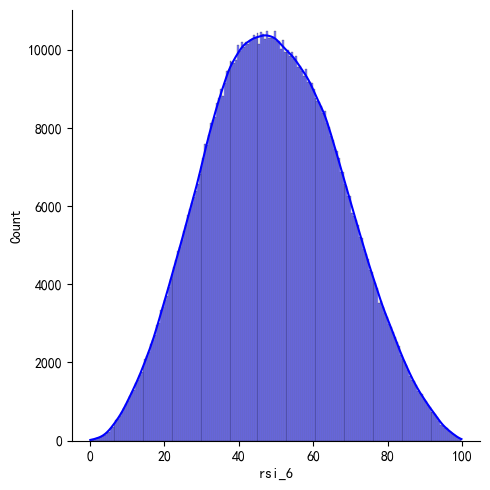

In [85]:
plot = sns.displot(tezheng,x='rsi_6',kde=True,color='b')

#### 相关性分析

1.26% (0.00%)


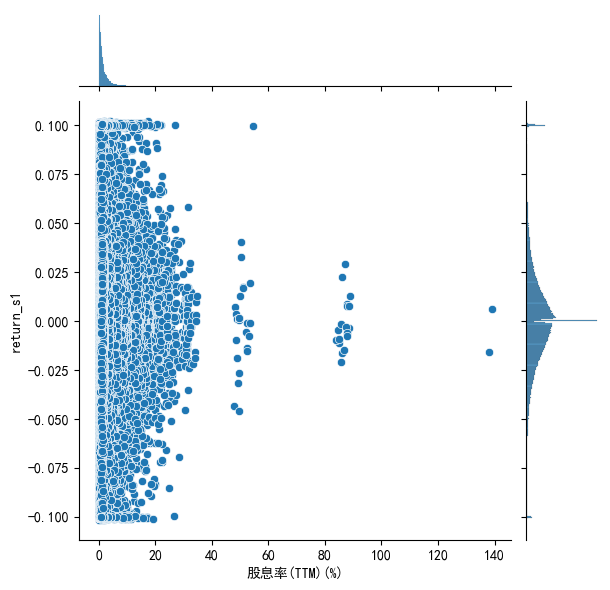

In [86]:
factor='股息率(TTM)(%)'
target='return_s1'

j=sns.jointplot(x=factor, y=target, data=tezheng,kind='scatter')
r, p = spearmanr(tezheng[factor], tezheng[target])
print(f'{r:,.2%} ({p:.2%})')#R为相关系数 P为对应的P值

#### 特征矩阵的多因子相关性分析

* sns.clustermap

`sns.clustermap` 是 Seaborn 库中的一个高级函数，用于生成带有层次聚类的热力图（Hierarchical Clustering Heatmap）。它的主要目的是对数据矩阵（如相关系数矩阵、表达数据等）进行可视化，并通过行和列的聚类来揭示数据内部的结构和模式。

`sns.clustermap` 的意义和特点包括：

1. **数据结构发现**：通过对数据集的行和列应用层次聚类算法（如平均链接法、单连接法、完全连接法等），`clustermap` 可以发现数据中的隐藏群体或模块，这对于探索复杂数据集中的自然分组尤为有用。

2. **热力图可视化**：以颜色编码的方式展示数据值，颜色的深浅代表数值的高低，直观地展示数据矩阵中的数值分布和强度。这对于观察变量间相对大小和模式非常有帮助。

3. **聚类指示**：通过 dendrogram（树状图）展示行和列的聚类关系，用户可以直接从图中读取哪些行（或列）被聚类在一起，从而理解数据的分组依据。

4. **交互式探索**：生成的热力图通常具有交互性（取决于使用的环境，如 Jupyter Notebook），用户可以放大、缩小或悬停查看具体的数值，便于详细分析。

5. **高级定制**：提供了丰富的参数选项，允许用户自定义颜色方案、聚类方法、距离度量、注释、图例等，以满足特定分析需求。

总的来说，`sns.clustermap` 是一个强大的数据分析和可视化工具，尤其适用于生物学（如基因表达分析）、社会科学、市场研究等领域中，需要从大规模数据集中寻找模式、相关性和分类的场景。通过同时展示数据的数值强度和结构关系，它极大地增强了数据探索和解释的能力。

* sns.PairGrid

`sns.PairGrid` 是 Seaborn 库中的一个灵活的图形接口，用于创建成对关系的子图网格，主要用于绘制数据集中所有变量两两之间的关系图。这对理解多维数据集中的变量间相互作用非常有帮助。其意义和功能主要包括：

1. **灵活的布局**：`PairGrid` 会为数据集中的每一对变量创建一个子图，你可以自定义这些子图中显示的内容，比如在非对角线位置上绘制散点图表示两个变量之间的关系，在对角线位置上显示直方图或核密度估计图来展示单个变量的分布。

2. **自定义绘图类型**：通过 `map` 或 `map_upper`, `map_lower`, `map_diag` 方法，用户可以指定在每个子图上绘制何种类型的图表，比如散点图(scatterplot)、线性回归图(regplot)、核密度图(kdeplot)等，这使得 `PairGrid` 极其灵活，能够适应多种数据分析需求。

3. **分组和着色**：通过 `hue` 参数，可以在图表中根据另一个变量对数据点进行分组和着色，这对于探索第三个变量如何影响对变量间的关系尤为重要，增加了可视化分析的维度。

4. **高级控制**：`PairGrid` 提供了对每个子图的精细控制，允许用户调整图表的各个方面，如颜色、标记样式、标签等，以更好地讲述数据故事。

简而言之，`sns.PairGrid` 的核心意义在于提供了一种机制，用于系统性地探索数据集中所有变量之间的成对关系，同时保留了高度的可定制性，使数据科学家和分析师能够深入挖掘数据中的模式和关联，特别是在探索性数据分析阶段。

* sns.jointplot

`sns.jointplot` 是 Seaborn 库中的一个功能强大的函数，用于创建联合分布图（Joint Distribution Plot）。这种图表主要用于可视化两个连续变量之间的关系，同时提供它们各自分布的概览。Jointplot 结合了散点图（展示两个变量之间的成对关系）和单变量分布的可视化（通常是直方图或核密度估计图，KDE），从而在一个图表中提供了两种变量联合及边际分布的完整视图。

`sns.jointplot` 的意义和特点包括：

1. **双变量关系展示**：通过散点图（默认类型）展示两个连续变量之间的相互关系，如相关性、聚集模式等。

2. **边际分布**：除了中心的散点图，图表两侧或顶部底部还会显示每个变量的分布，通常使用直方图或核密度估计图（KDE plot），帮助理解每个变量的单独分布特性。

3. **多种可视化选项**：`jointplot` 允许用户选择不同的图形类型（如散点图 scatter、回归线 reg、残差图 resid、核密度图 kde、六边形图 hex）以及统计函数来进一步分析变量间的关系。

4. **探索性分析**：非常适合探索性数据分析，因为它快速提供了关于两个变量如何一起变化以及它们各自的分布情况的信息，有助于假设检验和发现潜在的相关性。

5. **灵活定制**：用户可以根据需要调整颜色、大小、比例等图表属性，以及添加额外的统计拟合线，以更好地解释或描述数据特性。

总之，`sns.jointplot` 提供了一种强大的方式来综合分析两个连续变量之间的复杂关系，并且通过边际分布的展示，使得对这两个变量的单独理解以及它们之间的联合分布有了更加全面的视角，这对于统计分析和数据探索而言是非常有价值的。

In [88]:
te_corr=tezheng.corr()

In [90]:
te_corr.sort_values(by='return_s1',ascending=False)

,open,high,low,close,volume,成交额(千元),换手率(%),量比,市盈率(静态),市盈率(TTM),...,rsi_6,rsi_24,up,down,return_30,return_5,return_10,close-o,high-l,return_s1
return_s1,-0.002781,-0.002701,-0.002671,-0.002690,-0.010789,-0.011780,-0.030243,-0.014275,-0.003174,-0.000616,...,0.012287,-0.001576,-0.002655,-0.002691,-0.007671,0.008091,0.003990,0.003882,-0.003159,1.000000
rsi_6,0.016514,0.018744,0.017765,0.019651,0.132404,0.145176,0.254396,0.224125,0.041311,0.000531,...,1.000000,0.768101,0.005206,0.004033,0.491441,0.775536,0.765123,0.135416,0.042053,0.012287
return_5,0.008235,0.010136,0.009223,0.010894,0.142120,0.152843,0.291029,0.234986,0.041162,0.001682,...,0.775536,0.566387,-0.000401,-0.002035,0.394584,1.000000,0.700945,0.114734,0.032832,0.008091
股息率(%),0.025713,0.025004,0.026291,0.025584,-0.015134,-0.084152,-0.137976,-0.000943,-0.203916,-0.012941,...,-0.032199,-0.066985,0.024366,0.029261,-0.063777,-0.029812,-0.041034,-0.005181,-0.011977,0.006233
return_10,0.013507,0.015153,0.013945,0.015370,0.169580,0.189296,0.350873,0.140443,0.057836,0.000842,...,0.765123,0.703014,0.002090,-0.000972,0.567529,0.700945,1.000000,0.080467,0.044950,0.003990
close-o,0.001610,0.015036,0.012924,0.024808,0.020167,0.052441,0.019925,0.034984,0.006326,0.000228,...,0.135416,0.078153,0.007611,0.005140,0.050211,0.114734,0.080467,1.000000,0.068582,0.003882
股息率(TTM)(%),0.024797,0.024083,0.025357,0.024658,-0.012740,-0.079034,-0.135914,-0.003163,-0.214485,-0.015713,...,-0.043280,-0.082046,0.023466,0.028307,-0.074283,-0.036254,-0.048661,-0.005688,-0.012458,0.003668
市盈率(TTM),-0.003790,-0.003778,-0.003795,-0.003784,0.000049,-0.001229,0.011780,0.001505,0.068595,1.000000,...,0.000531,-0.000388,-0.003782,-0.003846,-0.001574,0.001682,0.000842,0.000228,-0.002832,-0.000616
市盈率(动态),-0.006395,-0.006164,-0.006569,-0.006343,-0.004149,0.022648,0.050468,0.002822,0.199799,0.013479,...,0.018051,0.033446,-0.006166,-0.007625,0.043888,0.021153,0.030090,0.002159,0.005257,-0.000868
dong10,0.056435,0.060502,0.059289,0.062556,0.038306,0.097396,0.050601,0.019326,0.017272,0.000340,...,0.241366,0.219087,0.012619,0.011342,0.169959,0.202761,0.289318,0.264635,0.084648,-0.001090


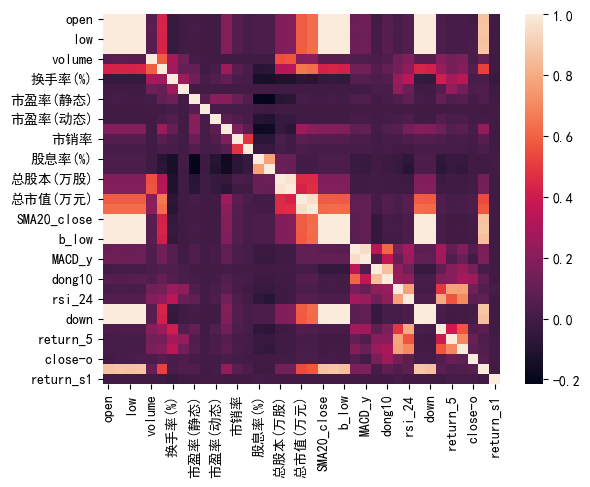

In [94]:
sns.heatmap(te_corr)
plt.show()

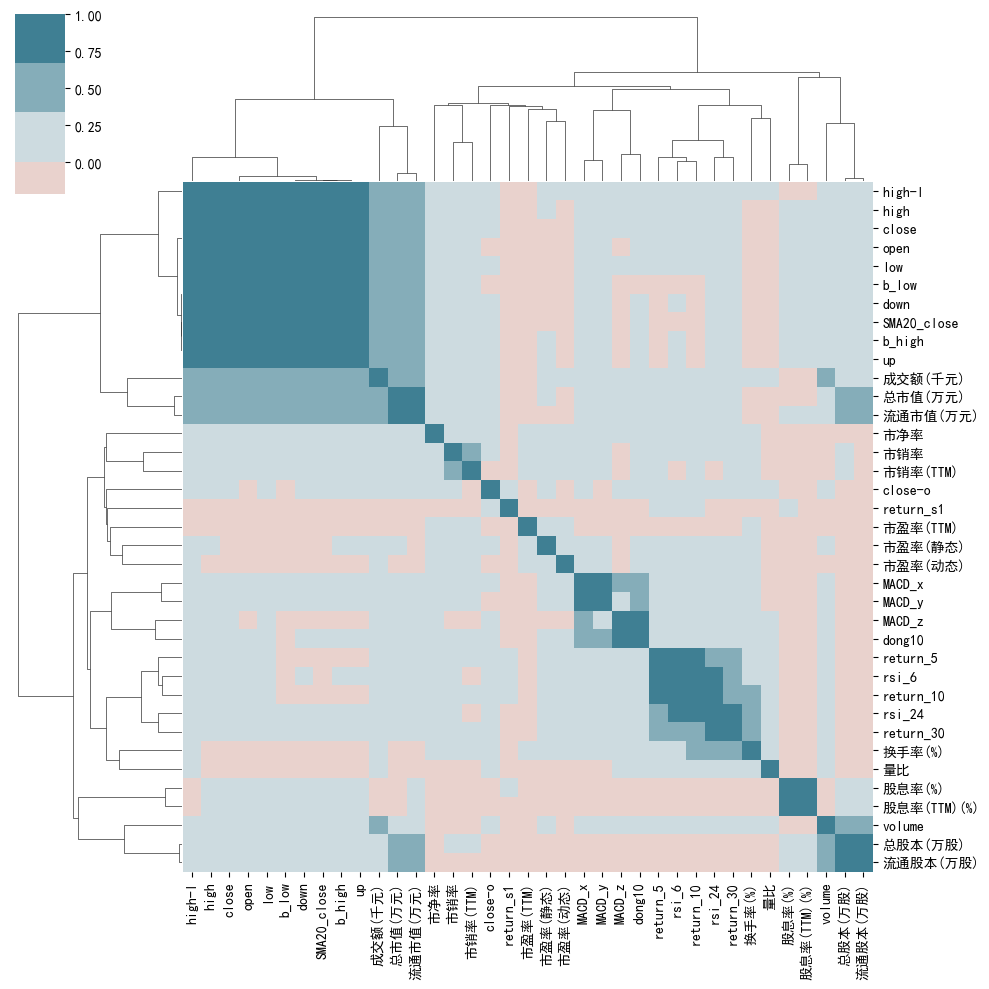

In [91]:
sns.clustermap(te_corr, cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)
plt.gcf().set_size_inches((10, 10))

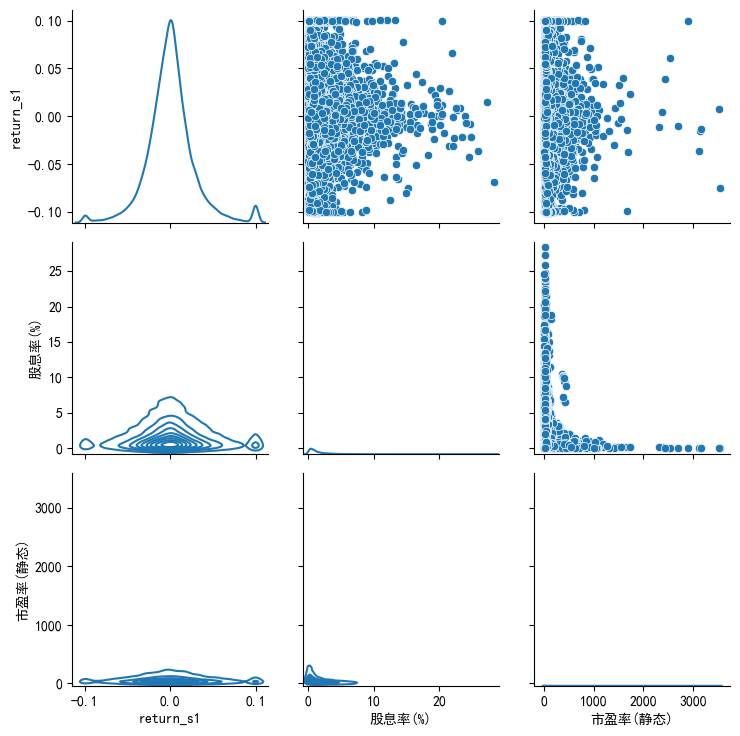

In [92]:
g = sns.PairGrid(tezheng.sample(frac=0.05),vars=['return_s1','股息率(%)','市盈率(静态)'])
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot)